<a href="https://colab.research.google.com/github/bishoy576/Sentiment-Analysis-on-Movie-reviews/blob/main/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("sst", "default")

In [ ]:
print(list(dataset['train']['tokens'])[:5])
print(list(dataset['train']['sentence'])[:5])

["The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.", "The|gorgeously|elaborate|continuation|of|``|The|Lord|of|the|Rings|''|trilogy|is|so|huge|that|a|column|of|words|can|not|adequately|describe|co-writer\\/director|Peter|Jackson|'s|expanded|vision|of|J.R.R.|Tolkien|'s|Middle-earth|.", 'Singer\\/composer|Bryan|Adams|contributes|a|slew|of|songs|--|a|few|potential|hits|,|a|few|more|simply|intrusive|to|the|story|--|but|the|whole|package|certainly|captures|the|intended|,|er|,|spirit|of|the|piece|.', "You|'d|think|by|now|America|would|have|had|enough|of|plucky|British|eccentrics|with|hearts|of|gold|.", 'Yet|the|act|is|still|charming|here|.']
["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", "The gorgeously elaborate continuation

In [ ]:
# Load your training and testing data (replace with your data loading)
train_data, train_labels = np.array(dataset['train']['tokens']), np.array(dataset['train']['label'])
test_data, test_labels = np.array(dataset['test']['tokens']), np.array(dataset['test']['label'])

def map_to_classes(arr):
  for i, el in enumerate(arr):
    if el <= 0.2:
      arr[i] = 0
    elif el <= 0.4:
      arr[i] = 1
    elif el <= 0.6:
      arr[i] = 2
    elif el <= 0.8:
      arr[i] = 3
    elif el <= 1:
      arr[i] = 4



In [ ]:
map_to_classes(train_labels)
train_labels = train_labels.astype(np.int8)
map_to_classes(test_labels)
test_labels = test_labels.astype(np.int8)

In [ ]:
np.unique(train_labels)

array([0, 1, 2, 3, 4], dtype=int8)

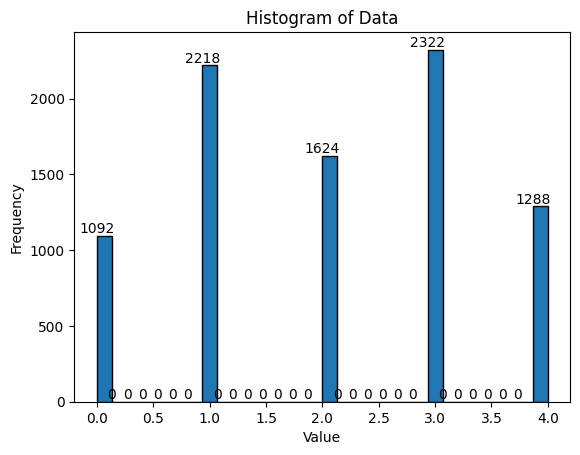

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram

plt.hist(train_labels, bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(False)

# Add frequency labels over each bar
hist, bins = np.histogram(train_labels, bins=30)
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(hist[i]), ha='center', va='bottom')

plt.show()

In [ ]:
from logging import error
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix
class NaiveBayes:
  def train(self, data, labels,  classes):
    logprior = [None] * 5
    Ndoc = data.shape[0]
    for c in classes:
      Nc = np.sum(labels == c)
      logprior[c] = np.log(Nc / Ndoc)
    vocabulary = {}
    for sentence in data:
      words = sentence.lower().split('|')
      for word in words:
        if word not in vocabulary:
          vocabulary[word] = len(vocabulary)
    def create_empty_array():
       return np.array([])
    bigdoc = defaultdict(create_empty_array)
    for sentence, label in zip(data, labels):
      bigdoc[label] = np.concatenate([bigdoc[label], np.array(sentence.lower().split('|'))])
    loglikelihood = np.zeros((len(vocabulary), 5))
    V = len(vocabulary)
    for word in vocabulary:
      for c in classes:
        count = np.sum(bigdoc[c] == word)
        loglikelihood[vocabulary[word], c] = np.log((count + 1) / (len(bigdoc[c]) + V))
    self.logprior = logprior
    self.loglikelihood = loglikelihood
    self.vocabulary = vocabulary
    self.V = V

  def predict(self, testdoc, classes):
    sum = np.zeros(5)
    words = testdoc.lower().split('|')
    for c in classes:
      sum[c] = self.logprior[c]
      for i, word in enumerate(words):
        if word in self.vocabulary:
          sum[c] += self.loglikelihood[self.vocabulary[word], c]
    return np.argmax(sum)










In [ ]:
model = NaiveBayes()
model.train(train_data,train_labels , range(5))
predicted_labels_original = np.array([model.predict(example, range(5)) for example in test_data])
predicted_labels_original[:7]

array([3, 3, 3, 3, 3, 2, 2])

In [ ]:
print(model.loglikelihood[model.vocabulary["i"]])

[-6.08981822 -6.22509988 -6.48650425 -6.4461366  -6.59228593]


In [ ]:
def confusion_matrix(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Predicted and true labels must have the same size.")

    num_classes = np.unique(y_true).shape[0]
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        confusion_matrix[true_label, pred_label] += 1

    return confusion_matrix


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
# Define pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=lambda x: x.split('|'))),  # Adjust CountVectorizer to match your preprocessing
    ('classifier', MultinomialNB())
])

# Train pipeline
pipeline.fit(train_data, train_labels)

# Predict
predicted_labels_sklearn = pipeline.predict(test_data)



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


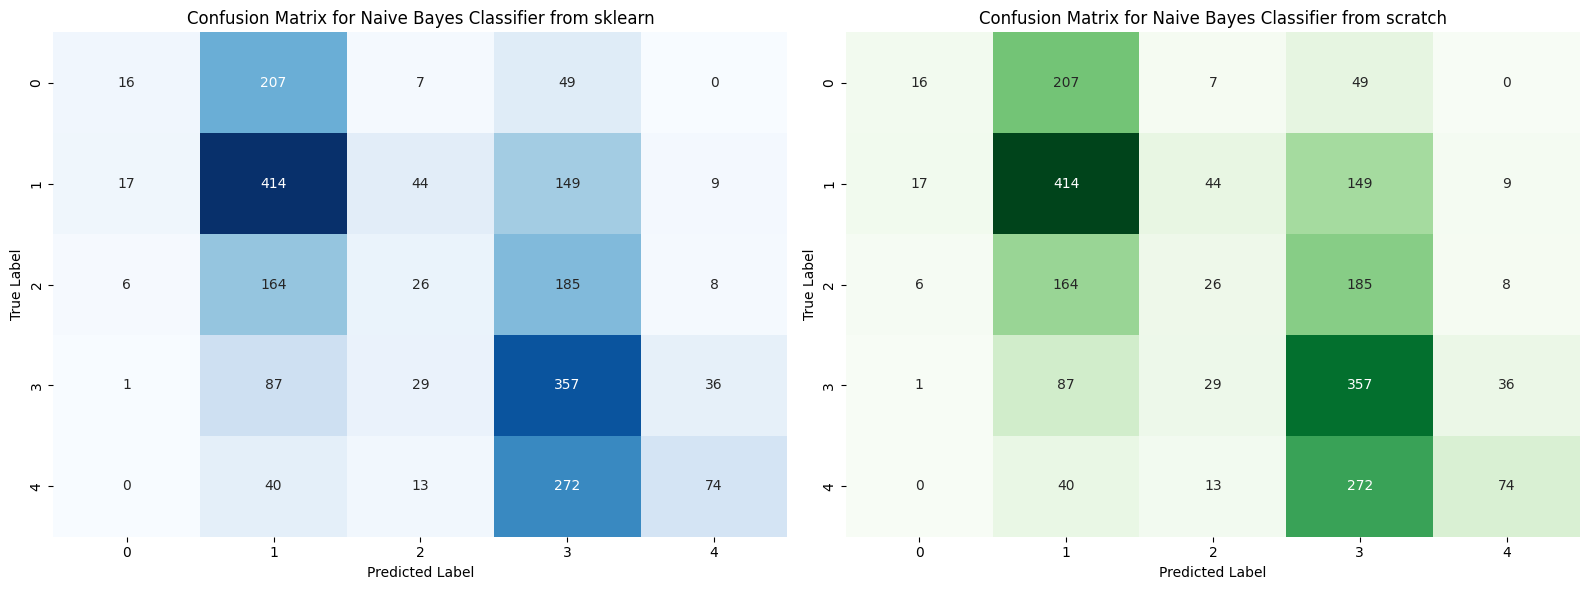

In [ ]:
import seaborn as sns
conf_mat_sklearn = confusion_matrix(test_labels, predicted_labels_sklearn)
conf_mat_original = confusion_matrix(test_labels, predicted_labels_original)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figure size as needed


sns.heatmap(conf_mat_sklearn, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax1)
ax1.set_xlabel("Predicted Label")
ax1.set_ylabel("True Label")
ax1.set_title("Confusion Matrix for Naive Bayes Classifier from sklearn")

# Plot the second heatmap on the second subplot
sns.heatmap(conf_mat_original, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax2)
ax2.set_xlabel("Predicted Label")
ax2.set_ylabel("True Label")
ax2.set_title("Confusion Matrix for Naive Bayes Classifier from scratch")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()




In [ ]:
from tabulate import tabulate

def precision(confusion_matrix, class_index):
    true_positives = confusion_matrix[class_index, class_index]
    false_positives = np.sum(confusion_matrix[:, class_index]) - true_positives
    if true_positives + false_positives == 0:
        return 0
    return true_positives / (true_positives + false_positives)


def recall(confusion_matrix, class_index):
    true_positives = confusion_matrix[class_index, class_index]
    false_negatives = np.sum(confusion_matrix[class_index, :]) - true_positives
    if true_positives + false_negatives == 0:
        return 0
    return true_positives / (true_positives + false_negatives)


def f1_score(confusion_matrix, class_index, beta=1):
    precision_val = precision(confusion_matrix, class_index)
    recall_val = recall(confusion_matrix, class_index)
    if precision_val + recall_val == 0:
        return 0
    return (1 + beta**2) * precision_val * recall_val / ((beta**2) * precision_val + recall_val)


def calculate_metrics(confusion_matrix):
   num_classes = confusion_matrix.shape[0]
   class_wise_metrics = {}
   for class_index in range(num_classes):
       class_wise_metrics[f"Class {class_index}"] = {
           "Precision": precision(confusion_matrix, class_index),
           "Recall": recall(confusion_matrix, class_index),
           "F1-Score": f1_score(confusion_matrix, class_index),
       }

   # Macro-average (average across classes without considering class imbalance)
   macro_precision = np.mean([precision(confusion_matrix, i) for i in range(num_classes)])
   macro_recall = np.mean([recall(confusion_matrix, i) for i in range(num_classes)])
   macro_f1 = np.mean([f1_score(confusion_matrix, i) for i in range(num_classes)])

   metrics = {
       "Class-wise Metrics": class_wise_metrics,
       "Macro-averaged Precision": macro_precision,
       "Macro-averaged Recall": macro_recall,
       "Macro-averaged F1-Score": macro_f1,
   }

   return metrics

def tabulate_metrics(metrics):
    class_wise_metrics = metrics["Class-wise Metrics"]
    macro_precision = metrics["Macro-averaged Precision"]
    macro_recall = metrics["Macro-averaged Recall"]
    macro_f1 = metrics["Macro-averaged F1-Score"]

    table = []
    for class_name, class_metrics in class_wise_metrics.items():
        table.append([class_name,
                      class_metrics["Precision"],
                      class_metrics["Recall"],
                      class_metrics["F1-Score"]])

    table.append(["Macro-average",
                  macro_precision,
                  macro_recall,
                  macro_f1])

    headers = ["Class", "Precision", "Recall", "F1-Score"]
    return tabulate(table, headers, tablefmt="grid")


metrics_original_by_original = calculate_metrics(conf_mat_original)
metrics_sklearn_by_original = calculate_metrics(conf_mat_sklearn)



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics_sklearn(y_true, y_pred):
    num_classes = len(set(y_true))

    class_wise_metrics = {}
    for class_index in range(num_classes):
        class_wise_metrics[f"Class {class_index}"] = {
            "Precision": precision_score(y_true, y_pred, average=None)[class_index],
            "Recall": recall_score(y_true, y_pred, average=None)[class_index],
            "F1-Score": f1_score(y_true, y_pred, average=None)[class_index],
        }

    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    metrics = {
        "Class-wise Metrics": class_wise_metrics,
        "Macro-averaged Precision": macro_precision,
        "Macro-averaged Recall": macro_recall,
        "Macro-averaged F1-Score": macro_f1,
    }

    return metrics

# print(type(conf_mat_sklearn))
# Example usage:
metrics_sklearn_by_sklearn = calculate_metrics_sklearn(test_labels, predicted_labels_sklearn)
# metrics_sklearn_by_original = calculate_metrics(conf_mat_sklearn)
# metrics_original_by_original = calculate_metrics(conf_mat_original)
metrics_original_by_sklearn = calculate_metrics_sklearn(test_labels, predicted_labels_original)
table = tabulate_metrics(metrics_sklearn_by_sklearn)
table2 = tabulate_metrics(metrics_sklearn_by_original)
table3 = tabulate_metrics(metrics_original_by_original)
table4 = tabulate_metrics(metrics_original_by_sklearn)
print(f"metrics of sklearn's output calculated by sklearn's model evaluation functions")
print(table)
print(f"metrics of sklearn's output calculated by original model evaluation functions")
print(table2)
print(f"metrics of original class output calculated by original model evaluation functions")
print(table3)
print(f"metrics of original class output calculated by sklearn model evaluation functions")
print(table4)



metrics of sklearn's output calculated by sklearn's model evaluation functions
+---------------+-------------+-----------+------------+
| Class         |   Precision |    Recall |   F1-Score |
+===============+=============+===========+============+
| Class 0       |    0.4      | 0.0573477 |   0.100313 |
+---------------+-------------+-----------+------------+
| Class 1       |    0.453947 | 0.654028  |   0.535922 |
+---------------+-------------+-----------+------------+
| Class 2       |    0.218487 | 0.066838  |   0.102362 |
+---------------+-------------+-----------+------------+
| Class 3       |    0.352767 | 0.7       |   0.46912  |
+---------------+-------------+-----------+------------+
| Class 4       |    0.582677 | 0.185464  |   0.281369 |
+---------------+-------------+-----------+------------+
| Macro-average |    0.401576 | 0.332736  |   0.297817 |
+---------------+-------------+-----------+------------+
metrics of sklearn's output calculated by original model evaluatio